# The Operator class

This page shows how to use the [`Operator`](/api/qiskit/qiskit.quantum_info.Operator) class. For a high-level overview of operator representations in Qiskit, including the `Operator` class and others, see [Overview of operator classes](./operators-overview).

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import CXGate, RXGate, XGate
from qiskit.quantum_info import Operator, Pauli, process_fidelity

## Convert classes to Operators

Several other classes in Qiskit can be directly converted to an `Operator` object using the operator initialization method. For example:

* `Pauli` objects
* `Gate` and `Instruction` objects
* `QuantumCircuit` objects

Note that the last point means you can use the `Operator` class as a unitary simulator to compute the final unitary matrix for a quantum circuit, without having to call a simulator backend. If the circuit contains any unsupported operations, an exception is raised. Unsupported operations are: measure, reset, conditional operations, or a gate that does not have a matrix definition or decomposition in terms of gate with matrix definitions.

In [2]:
# Create an Operator from a Pauli object

pauliXX = Pauli("XX")
Operator(pauliXX)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [3]:
# Create an Operator for a Gate object
Operator(CXGate())

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [4]:
# Create an operator from a parameterized Gate object
Operator(RXGate(np.pi / 2))

Operator([[0.70710678+0.j        , 0.        -0.70710678j],
          [0.        -0.70710678j, 0.70710678+0.j        ]],
         input_dims=(2,), output_dims=(2,))


In [5]:
# Create an operator from a QuantumCircuit object
circ = QuantumCircuit(10)
circ.h(0)
for j in range(1, 10):
    circ.cx(j - 1, j)

# Convert circuit to an operator by implicit unitary simulation
Operator(circ)

Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


## Use Operators in circuits

Unitary `Operators` can be directly inserted into a `QuantumCircuit` using the `QuantumCircuit.append` method. This converts the `Operator` into a `UnitaryGate` object, which is added to the circuit.

If the operator is not unitary, an exception is raised. This can be checked using the `Operator.is_unitary()` function, which returns `True` if the operator is unitary and `False` otherwise.

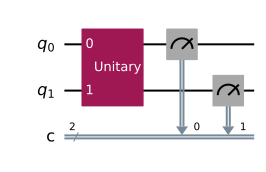

In [6]:
# Create an operator
XX = Operator(Pauli("XX"))

# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(XX, [0, 1])
circ.measure([0, 1], [0, 1])
circ.draw("mpl")

Note that in the above example the operator is initialized from a `Pauli` object. However, the `Pauli` object may also be directly inserted into the circuit itself and will be converted into a sequence of single-qubit Pauli gates:

In [7]:
# Add to a circuit
circ2 = QuantumCircuit(2, 2)
circ2.append(Pauli("XX"), [0, 1])
circ2.measure([0, 1], [0, 1])
circ2.draw()

┌────────────┐┌─┐   
q_0: ┤0           ├┤M├───
     │  Pauli(XX) │└╥┘┌─┐
q_1: ┤1           ├─╫─┤M├
     └────────────┘ ║ └╥┘
c: 2/═══════════════╩══╩═
                    0  1

## Combine Operators

Operators may be combined using several methods.

### Tensor product

Two operators $A$ and $B$ can be combined into a tensor product operator $A\otimes B$ using the `Operator.tensor` function. Note that if both $A$ and $B$ are single-qubit operators, then `A.tensor(B)` = $A\otimes B$ will have the subsystems indexed as matrix $B$  on subsystem 0, and matrix $A$ on subsystem 1.

In [8]:
A = Operator(Pauli("X"))
B = Operator(Pauli("Z"))
A.tensor(B)

Operator([[ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


### Tensor expansion

A closely related operation is `Operator.expand`, which acts like a tensor product but in the reverse order. Hence, for two operators $A$ and $B$ you have `A.expand(B)` = $B\otimes A$ where the subsystems are indexed as matrix $A$ on subsystem 0, and matrix $B$ on subsystem 1.

In [9]:
A = Operator(Pauli("X"))
B = Operator(Pauli("Z"))
A.expand(B)

Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


### Composition

You can also compose two operators $A$ and $B$ to implement matrix multiplication using the `Operator.compose` method. `A.compose(B)` returns the operator with matrix $B.A$:

In [10]:
A = Operator(Pauli("X"))
B = Operator(Pauli("Z"))
A.compose(B)

Operator([[ 0.+0.j,  1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))


You can also compose in the reverse order by applying $B$ in front of $A$ using the `front` kwarg of `compose`:  `A.compose(B, front=True)` = $A.B$:

In [11]:
A = Operator(Pauli("X"))
B = Operator(Pauli("Z"))
A.compose(B, front=True)

Operator([[ 0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))


### Subsystem composition

Note that the previous compose requires that the total output dimension of the first operator $A$ is equal to the total input dimension of the composed operator $B$ (and similarly, the output dimension of $B$ must be equal to the input dimension of $A$ when composing with `front=True`).

You can also compose a smaller operator with a selection of subsystems on a larger operator using the `qargs` kwarg of `compose`, either with or without `front=True`. In this case, the relevant input and output dimensions of the subsystems being composed must match. *Note that the smaller operator must always be the argument of the* `compose` *method.*

For example, to compose a two-qubit gate with a three-qubit operator:

In [12]:
# Compose XZ with a 3-qubit identity operator
op = Operator(np.eye(2**3))
XZ = Operator(Pauli("XZ"))
op.compose(XZ, qargs=[0, 2])

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


In [13]:
# Compose YX in front of the previous operator
op = Operator(np.eye(2**3))
YX = Operator(Pauli("YX"))
op.compose(YX, qargs=[0, 2], front=True)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j],
          [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


### Linear combinations

Operators may also be combined using standard linear operators for addition, subtraction, and scalar multiplication by complex numbers.

In [14]:
XX = Operator(Pauli("XX"))
YY = Operator(Pauli("YY"))
ZZ = Operator(Pauli("ZZ"))

op = 0.5 * (XX + YY - 3 * ZZ)
op

Operator([[-1.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  1.5+0.j,  1. +0.j,  0. +0.j],
          [ 0. +0.j,  1. +0.j,  1.5+0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j, -1.5+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


An important point is that while `tensor`, `expand`, and `compose` preserves the unitarity of unitary operators, linear combinations do not; hence, adding two unitary operators will, in general, result in a non-unitary operator:

In [15]:
op.is_unitary()

False

### Implicit conversion to Operators

Note that for all the following methods, if the second object is not already an `Operator` object, it is implicitly converted into one by the method. This means that matrices can be passed in directly without being explicitly converted to an `Operator` first. If the conversion is not possible, an exception is raised.

In [16]:
# Compose with a matrix passed as a list
Operator(np.eye(2)).compose([[0, 1], [1, 0]])

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))


## Compare Operators

Operators implement an equality method that can be used to check if two operators are approximately equal.

In [17]:
Operator(Pauli("X")) == Operator(XGate())

True

Note that this checks that each matrix element of the operators is approximately equal; two unitaries that differ by a global phase are not considered equal:

In [18]:
Operator(XGate()) == np.exp(1j * 0.5) * Operator(XGate())

False

### Process fidelity

You can also compare operators using the `process_fidelity` function from the *Quantum Information* module. This is an information-theoretic quantity for how close two quantum channels are to each other, and in the case of unitary operators it does not depend on global phase.

In [19]:
# Two operators which differ only by phase
op_a = Operator(XGate())
op_b = np.exp(1j * 0.5) * Operator(XGate())

# Compute process fidelity
F = process_fidelity(op_a, op_b)
print("Process fidelity =", F)

Process fidelity = 1.0


Note that process fidelity is generally only a valid measure of closeness if the input operators are unitary (or CP in the case of quantum channels), and an exception is raised if the inputs are not CP.

## Next steps

<Admonition type="tip" title="Recommendations">
  - Explore the [Operator API](/api/qiskit/qiskit.quantum_info.Operator#operator) reference.
</Admonition>